# Data Preprocessing

## Michigan Inflation Expectation
https://fred.stlouisfed.org/series/MICH

## US CPI Rate
https://fred.stlouisfed.org/series/CPALTT01USM657N

In [105]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [106]:
PATH_FFR_PRE_2008 = 'data/FFR_pre_2008.csv'
df_pre_2008 = pd.read_csv(PATH_FFR_PRE_2008, low_memory=False)

PATH_FFR_POST_2008 = 'data/FFR_post_2008.csv'
df_post_2008 = pd.read_csv(PATH_FFR_POST_2008, low_memory=False)

PATH_UNEMPLOYMENT = 'data/UNRATE.csv'
df_unemployment = pd.read_csv(PATH_UNEMPLOYMENT, low_memory=False)
df_unemployment['DATE'] = pd.to_datetime(df_unemployment['DATE'])
df_unemployment.columns = ['date', 'unemployment']

PATH_INFLATION = 'data/PCE_inflation.csv'
df_inflation = pd.read_csv(PATH_INFLATION, low_memory=False)
df_inflation['DATE'] = pd.to_datetime(df_inflation['DATE'])
df_inflation.columns = ['date', 'inflation']

PATH_EXPECTED_CPI = 'data/Michigan Inflation Expectation.csv'
df_expected_cpi = pd.read_csv(PATH_EXPECTED_CPI, low_memory=False)
df_expected_cpi['DATE'] = pd.to_datetime(df_expected_cpi['DATE'])
df_expected_cpi.columns = ['date', 'expected_cpi']

PATH_PCE = 'data/PCE.csv'
df_pce = pd.read_csv(PATH_PCE, low_memory=False)
df_pce['DATE'] = pd.to_datetime(df_pce['DATE'])
df_pce.columns = ['date', 'pce']


In [107]:
# concatenate pre- and post-2008 FFR data, impute value for Dec 2008
df_pre_2008.columns = ['date', 'ffr']
df_dec_2008 = pd.DataFrame({'date':['2008-12-01'], 'ffr':[.250000]})
df_post_2008.columns = ['date', 'ffr']

df = pd.concat([df_pre_2008, df_dec_2008, df_post_2008], ignore_index=True)
df['date'] = pd.to_datetime(df['date'])
df.isna().sum()

date    0
ffr     0
dtype: int64

In [108]:
print("FFR data")
print(df.head(5))

print("Unemployment data")
print(df_unemployment.head(5))

print("CPI data")
print(df_inflation.head(5))

print("Expected CPI data")
print(df_expected_cpi.head(5))

FFR data
        date       ffr
0 1994-01-01  3.000000
1 1994-02-01  3.223214
2 1994-03-01  3.330645
3 1994-04-01  3.608333
4 1994-05-01  3.991935
Unemployment data
        date  unemployment
0 1994-01-01           6.6
1 1994-02-01           6.6
2 1994-03-01           6.5
3 1994-04-01           6.4
4 1994-05-01           6.1
CPI data
        date  inflation
0 1994-01-01       2.36
1 1994-02-01       2.35
2 1994-03-01       2.41
3 1994-04-01       2.30
4 1994-05-01       2.27
Expected CPI data
        date  expected_cpi
0 1978-01-01           5.2
1 1978-02-01           6.4
2 1978-03-01           6.3
3 1978-04-01           6.7
4 1978-05-01           6.9


In [ ]:
df['ffr_1m_change'] = df['ffr'] - df['ffr'].shift(1)  # 1-month change
# df['ffr_3m_change'] = df['ffr'] - df['ffr'].shift(3)  # 3-month change
# df['ffr_6m_change'] = df['ffr'] - df['ffr'].shift(6)  # 6-month change
# df['ffr_12m_change'] = df['ffr'] - df['ffr'].shift(12)  # 12-month change
# df['ffr_24m_change'] = df['ffr'] - df['ffr'].shift(24)  # 24-month change

# df= pd.merge(df, df_unemployment, left_on='date', right_on='date', how='outer')
df = pd.merge(df, df_unemployment, on='date', how='inner')
df= pd.merge(df, df_inflation, on='date', how='inner')
df= pd.merge(df, df_expected_cpi, on='date', how='inner')
df= pd.merge(df, df_pce, on='date', how='inner')

change_predictors = ['ffr', 'unemployment', 'inflation', 'expected_cpi', 'pce']
for change_predictor in change_


In [110]:
df

,date,ffr,ffr_1m_change,unemployment,inflation,expected_cpi,pce
0,1994-01-01,3.000000,NaN,6.6,2.36,2.8,4585.1
1,1994-02-01,3.223214,0.223214,6.6,2.35,2.8,4632.6
2,1994-03-01,3.330645,0.107431,6.5,2.41,3.0,4646.0
3,1994-04-01,3.608333,0.277688,6.4,2.30,3.0,4671.1
4,1994-05-01,3.991935,0.383602,6.1,2.27,3.1,4669.5
...,...,...,...,...,...,...,...
364,2024-05-01,5.500000,0.000000,4.0,2.86,3.3,19697.3
365,2024-06-01,5.500000,0.000000,4.1,2.83,3.0,19747.5
366,2024-07-01,5.500000,0.000000,4.3,2.79,2.9,19862.9
367,2024-08-01,5.500000,0.000000,4.2,2.72,2.8,19918.4


In [111]:
df.describe()

,date,ffr,ffr_1m_change,unemployment,inflation,expected_cpi,pce
count,369,369.000000,368.000000,369.000000,369.000000,369.000000,369.000000
mean,2009-05-01 16:00:00,2.605512,0.006250,5.596206,2.169051,3.049593,10442.041463
min,1994-01-01 00:00:00,0.250000,-0.975806,3.400000,0.800000,0.400000,4585.100000
25%,2001-09-01 00:00:00,0.250000,0.000000,4.300000,1.730000,2.700000,7121.700000
50%,2009-05-01 00:00:00,1.891667,0.000000,5.100000,2.040000,2.900000,10035.300000
75%,2017-01-01 00:00:00,5.250000,0.000000,6.100000,2.370000,3.200000,13005.900000
max,2024-09-01 00:00:00,6.500000,0.700000,14.800000,4.990000,5.400000,20024.300000
std,NaN,2.204385,0.178279,1.802546,0.732881,0.684380,3984.583035


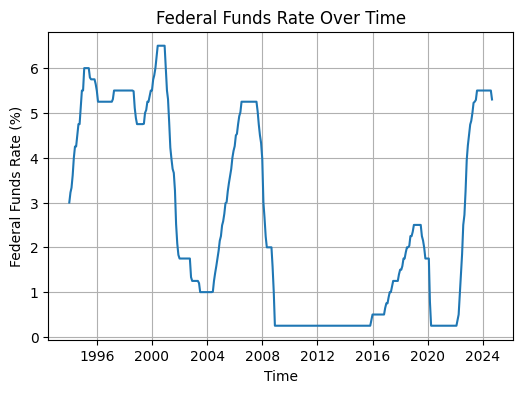

In [112]:
plt.figure(figsize=(6, 4))
plt.plot(df.date, df.ffr)
plt.title('Federal Funds Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Federal Funds Rate (%)')
plt.grid()
plt.show()

In [113]:
date = pd.to_datetime('1994-01-01')
month = pd.DateOffset(months=1)
while date < pd.to_datetime('2024-10-01'):
    if date not in df['date'].values:
        print('missing: '+str(date))
    date += month

In [114]:
df = df.dropna()

X = df[['unemployment', 'ffr', 'inflation', 'expected_cpi']]
X['unemployment_inflation'] = X['unemployment'] * X['inflation']
X['unemployment_expected_cpi'] = X['unemployment'] * X['expected_cpi']
X['inflation_expected_cpi'] = X['inflation'] * X['expected_cpi']
y = df['ffr_1m_change']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Coefficients: [-1.02934727e-01  1.15955101e-02 -4.08360964e-01 -4.40438104e-01
  3.94898612e-04  3.51004928e-02  1.19372402e-01]
Intercept: 1.3565858942136375


C:\Users\mmcph\AppData\Local\Temp\ipykernel_57620\1738853785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['unemployment_inflation'] = X['unemployment'] * X['inflation']
C:\Users\mmcph\AppData\Local\Temp\ipykernel_57620\1738853785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['unemployment_expected_cpi'] = X['unemployment'] * X['expected_cpi']


C:\Users\mmcph\AppData\Local\Temp\ipykernel_57620\1787328105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'predicted_ffr_change'] = model.predict(X)


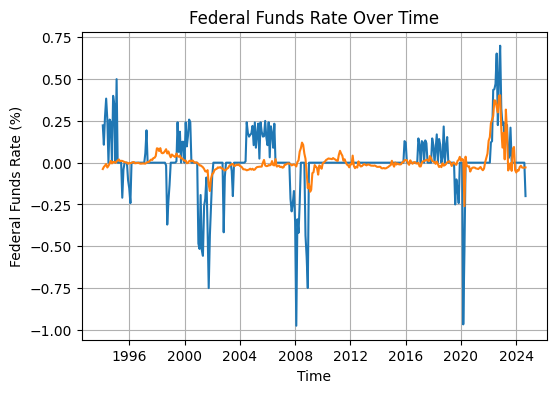

In [115]:
df.loc[:, 'predicted_ffr_change'] = model.predict(X)

plt.figure(figsize=(6, 4))
plt.plot(df.date, df.ffr_1m_change)
plt.plot(df.date, df.predicted_ffr_change)
plt.title('Federal Funds Rate Over Time')
plt.xlabel('Time')
plt.ylabel('Federal Funds Rate (%)')
plt.grid()
plt.show()